In [1]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'



/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [8]:
def coulombEffect(Z,A,rfrac=0.75):
    alpha=1/137
    hbar=.197
    R=1.1*A**(1/3)+.86*A**(-1/3)
    #if the rfrac is not specified, use 3/4.  
    return (-3*alpha*(Z-1)/(2*R)+alpha*(Z-1)/(2*R)*rfrac)*hbar


0.0
0.0027949112272293956
0.009122575858917641
0.01969718304826887


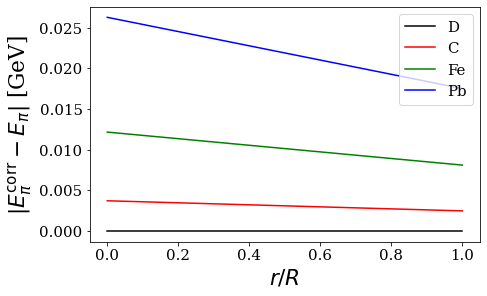

In [59]:
rfrac = np.linspace(0, 1, 101)
for Z, A, name, col in (1, 2, "D", 'k'),(6, 12, "C", 'r'), (26, 56, "Fe", 'g'), (82, 207, "Pb", 'b'):
    plt.plot(rfrac, abs(coulombEffect(Z,A,rfrac)), linestyle='-', label=name, color=col)
    print(abs(coulombEffect(Z,A,0.75)))
plt.xlabel("$r/R$")
plt.ylabel("$|E^{\\rm corr}_{\pi}-E_{\pi}|$ [GeV]")
plt.legend()
plt.show()

In [14]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

In [15]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    dfs_pair['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 3.98 s, sys: 485 ms, total: 4.47 s
Wall time: 5.17 s


In [24]:
mixtag='xQ2_'
dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}



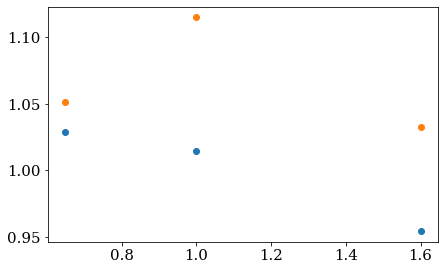

In [21]:
dfs_pair['Pb'].eval('h1_e=nu*h1_z',inplace=True)
dfs_pair['Pb'].eval('h2_e=nu*h2_z',inplace=True)

y1,x=np.histogram(dfs_pair['Pb'].eval("h1_cm_pt*(h1_e-.025)/h1_e"), bins=(.25, .4, .6,1.0))
y2,x=np.histogram(dfs_pair['Pb'].eval("h1_cm_pt"),bins=(.25, .4, .6,1.0))
plt.plot(x[1:]+x[:-1],y1/y2, marker='o', linestyle='')

y1,x=np.histogram(dfs_pair['Pb'].eval("h2_cm_pt*(h2_e+.025)/h2_e"), bins=(.25, .4, .6,0.8))
y2,x=np.histogram(dfs_pair['Pb'].eval("h2_cm_pt"),bins=(.25, .4, .6,1.0))
plt.plot(x[1:]+x[:-1],y1/y2, marker='o', linestyle='')

plt.show()

In [25]:
import R2h_module
import imp
imp.reload(R2h_module)
for key in list(dfs_mixed.keys()):
    isMC=False
    if 'GiBUU' in key:
        isMC=True
    dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
    print(f"\n\n{key}")
    if  'dphi' not in dfs_mixed[key].columns:
        dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
        dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
        dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
    dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
    dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
    dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

    mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
    dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
                                                             nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    



D_C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 3403326  (100.00  %)
2.2 < nu < 4.2 3361656  (98.78  %)
secondary hadrons are pions 2449421  (72.86  %)
(h1_pid*h2_pid)<0, opposite charge pions 930584  (37.99  %)
kinematic limits for h2_z 899056  (96.61  %)
kinematic limits for dphi 898616  (99.95  %)
kinematic limits for pair_mass 890515  (99.10  %)
leading hadrons are pions 890515  (100.00  %)
0.2<h2_p<5.0 890515  (100.00  %)
0.2<h1_p<5.0 890515  (100.00  %)
pt>0.07071067811865475 GeV 866977  (97.36  %)
10<h2_th 866977  (100.00  %)
Theta/P fiducial region selected for secondary hadron 816153  (94.14  %)
10< h1_th 816153  (100.00  %)
Theta/P fiducial region selected for trigger hadron 816153  (100.00  %)
Nom cuts for the pair applied (pi pi) 339912  (41.65  %)


C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 2509591  (100.00  %)
2.2 < nu < 4.2 2476511  (98.68  %)
secondary hadrons are pions 1581622  (63.86  %)
(h1_pid*h2_pid)<0, opposite charge 

In [27]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True)


key:  C
Entries before cut  131591
Q2>1.0 and Q2<4.0 131591  (100.00  %)
0.2<h1_p<5.0  131585  (100.00  %)
inelasticity < 0.85 131585  (100.00  %)
h1_pid = pions (trigger) 131585  (100.00  %)
2.2 < nu <4.2 129258  (98.23  %)
10< h1_th 129258  (100.00  %)
Theta/P fiducial region selected for trigger hadron 129258  (100.00  %)
Nom cuts for the trigger applied 44785  (34.65  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
secondary hadrons are pions 44785  (100.00  %)
(h1_pid*h2_pid)<0, opposite charge pions 35717  (79.75  %)
kinematic limits for h2_z 35636  (99.77  %)
kinematic limits for dphi 35596  (99.89  %)
kinematic limits for pair_mass 35415  (99.49  %)
leading hadrons are pions 35415  (100.00  %)
0.2<h2_p<5.0 35415  (100.00  %)
0.2<h1_p<5.0 35415  (100.00  %)
10<h2_th 35415  (100.00  %)
Theta/P fiducial region selected for secondary hadron 32420  (91.54  %)
10< h1_th 32420  (100.00  %)
Theta/P fiducial region

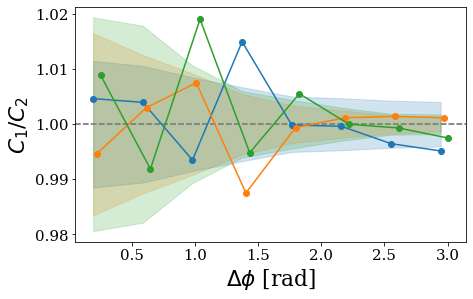

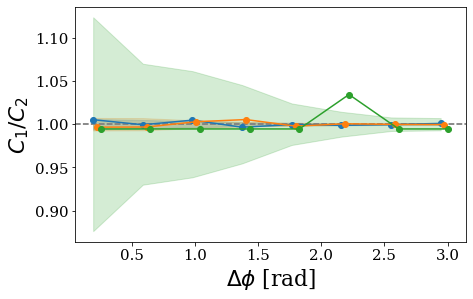

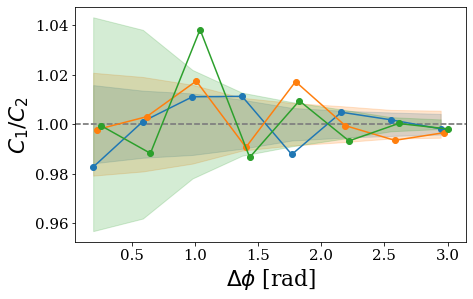

<ipython-input-81-11673c06818f>:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y*m+b)/y


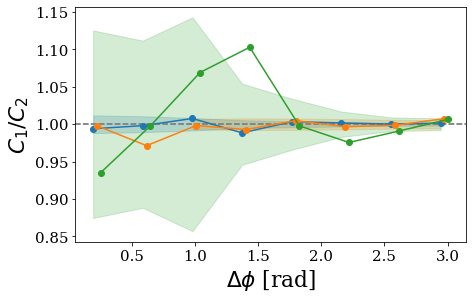

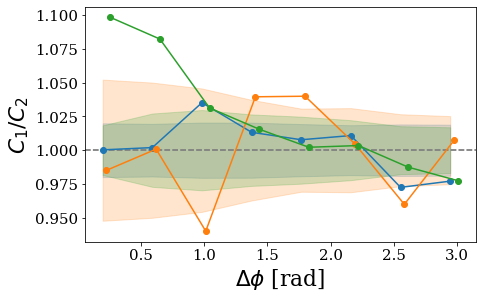

<ipython-input-81-11673c06818f>:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y*m+b)/y


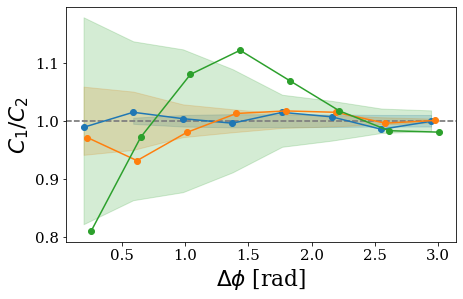

In [81]:
def get_envelope(y1,y2):
    y=y2/sum(y2)
    dy=y1/sum(y1)-y
    n= len(y1)
    
    m = (sum(dy**2*y)*n-sum(dy**2)*sum(y))/(sum(y**2)*n-sum(y)**2)
    b = sum(dy**2)/n-sum(y)/n*m
    return np.sqrt(y*m+b)/y
    #return np.sqrt(np.mean((y1/sum(y1)-y2/sum(y2))**2))/(y1/sum(y1))

for A, deltaE in  ("C", 0.0028), ("Fe", .0091), ("Pb",.020): 
    dfs_pair[A].eval('h1_e=nu*h1_z',inplace=True)
    dfs_pair[A].eval('h2_e=nu*h2_z',inplace=True)


    bins=(.25, .4, .6,1.0)
    for i in range(3):
        col = 'tab:blue tab:orange tab:green'.split()[i]
        cuts = f"h2_cm_pt*(h2_e+{deltaE})/h2_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h1_cm_pt*(h1_e-{deltaE})/h1_e>{bins[i]} and h1_cm_pt*(h1_e-{deltaE})/h1_e<{bins[i+1]}"
        df_slice = dfs_pair[A].query(cuts)

        y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        cuts = f"h2_cm_pt>.25  and h1_z>0.5 and h1_cm_pt>{bins[i]} and h1_cm_pt<{bins[i+1]}"
        df_slice = dfs_pair[A].query(cuts)
        y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        x=(x[1:]+x[:-1])/2

        r = y1/sum(y1)/(y2/sum(y2))
        dr = 1/np.sqrt(y1)*0
        plt.errorbar(x+i*.03,r, dr, color=col, marker='o')
        plt.axhline(1, color='0.5', alpha=0.7, linestyle='--')
        env=get_envelope(y1,y2)
        plt.fill_between(x, 1-env, 1+env, color=col, alpha=0.2)
        #print(np.sqrt(np.mean((r-1)**2)), min(dr), np.sum((r-1)**2/dr**2))
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.ylabel("$C_1/C_2$")
    plt.show()
    
    bins=(.25, .4, .6,0.8)
    for i in range(3):
        col = 'tab:blue tab:orange tab:green'.split()[i]
        cuts = f"h1_cm_pt*(h1_e+{deltaE})/h1_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h2_cm_pt*(h1_e+{deltaE})/h1_e>{bins[i]} and h2_cm_pt*(h1_e+{deltaE})/h1_e<{bins[i+1]}"
        df_slice = dfs_pair[A].query(cuts)

        y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        cuts = f"h1_cm_pt>.25  and h1_z>0.5 and h2_cm_pt>{bins[i]} and h2_cm_pt<{bins[i+1]}"
        df_slice = dfs_pair[A].query(cuts)
        y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9))
        x=(x[1:]+x[:-1])/2
        r = y1/sum(y1)/(y2/sum(y2))
        dr = 1/np.sqrt(y1)*0
        #print(np.sqrt(np.mean((r-1)**2)), min(dr), np.sum((r-1)**2/dr**2))
        plt.axhline(1, color='0.5', alpha=0.7, linestyle='--')
        plt.errorbar(x+i*.03,r, dr, color=col, marker='o')
        env=get_envelope(y1,y2)
        plt.fill_between(x, 1-env, 1+env, color=col, alpha=0.2)
    plt.xlabel("$\Delta\phi$ [rad]")
    plt.ylabel("$C_1/C_2$")
    plt.show()

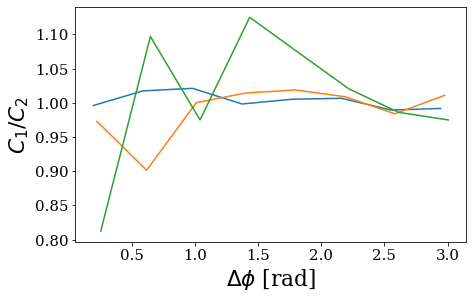

In [46]:
dfs_pair['Pb'].eval('h1_e=nu*h1_z',inplace=True)
dfs_pair['Pb'].eval('h2_e=nu*h2_z',inplace=True)

bins=(.25, .4, .6,0.8)
for i in range(3):
    cuts = f"h1_cm_pt*(h1_e+{deltaE})/h1_e>.25 and h1_z*(h1_e-{deltaE})/h1_e>.5 and h2_cm_pt*(h1_e+{deltaE})/h1_e>{bins[i]} and h2_cm_pt*(h1_e+{deltaE})/h1_e<{bins[i+1]}"
    df_slice = dfs_pair['Pb'].query(cuts)
    
    y1,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9), density=True)
    cuts = f"h1_cm_pt>.25  and h1_z>0.5 and h2_cm_pt>{bins[i]} and h2_cm_pt<{bins[i+1]}"
    df_slice = dfs_pair['Pb'].query(cuts)
    y2,x=np.histogram(df_slice.dphi, bins=np.linspace(0, np.pi, 9), density=True)
    x=(x[1:]+x[:-1])/2
    plt.errorbar(x+i*.03,y1/y2)
plt.xlabel("$\Delta\phi$ [rad]")
plt.ylabel("$C_1/C_2$")
plt.show()